<a href="https://colab.research.google.com/github/srijha1408/NM-project/blob/main/phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving creditcard.csv.csv to creditcard.csv.csv
Columns in the dataset: ['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'Industry', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved']
Data shape: (690, 16)
Approved
0    0.555072
1    0.444928
Name: proportion, dtype: float64
Resampled data shape: (766, 15)
Resampled approval rate: 0.5000

🧠 Training Logistic Regression...
✅ Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.87      0.84      0.86        77

    accuracy                           0.86       154
   macro avg       0.86      0.86      0.86       154
weighted avg       0.86      0.86      0.86       154

ROC-AUC: 0.9430

🧠 Training Random Forest...
✅ Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     

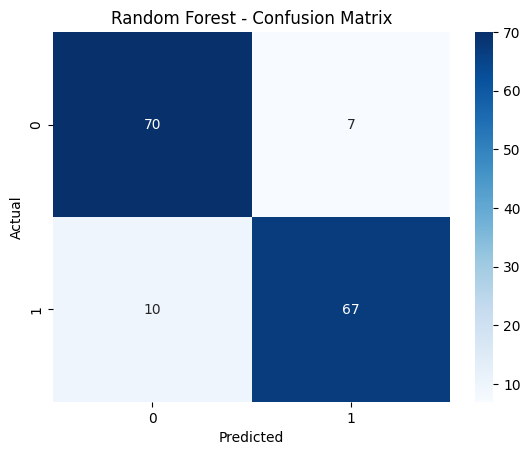

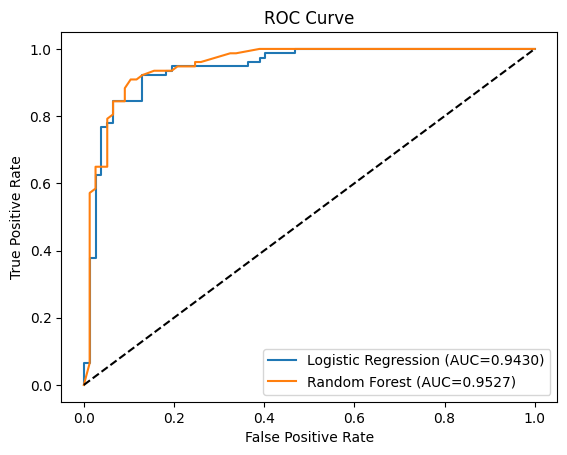

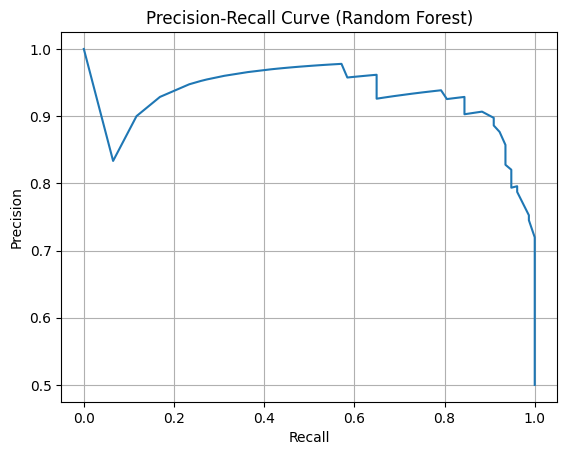

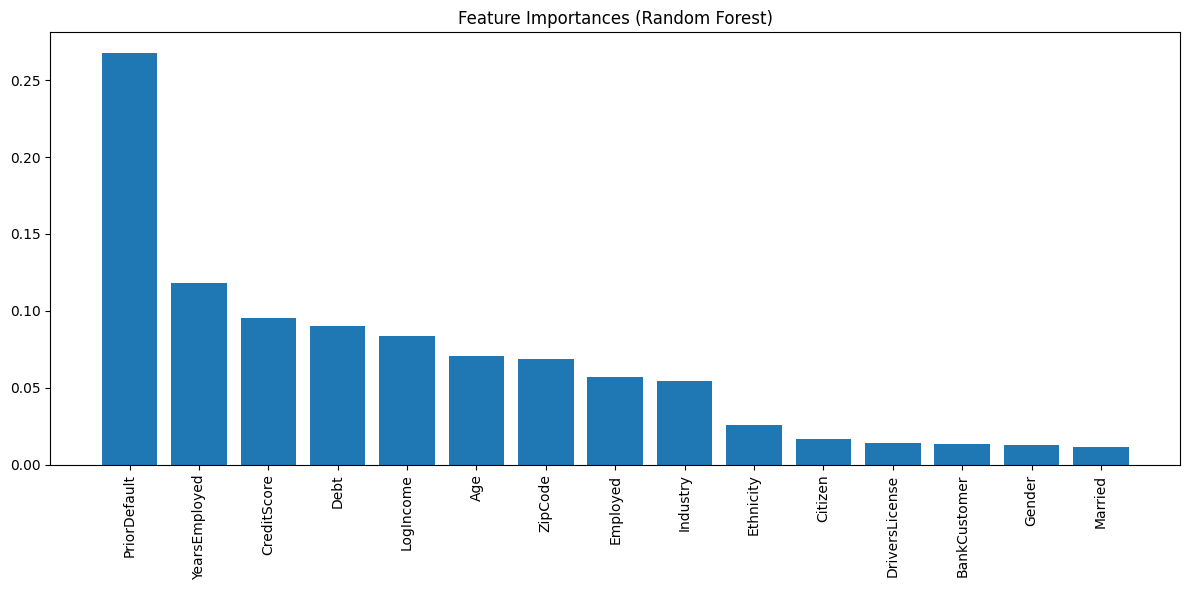

🎯 Model saved as 'rf_model.pkl'


In [1]:
# Step 1: Install required packages (only needed in Colab)
!pip install -q imbalanced-learn joblib

# Step 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve,
                             precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE
import joblib

# Step 3: Upload the dataset
from google.colab import files
uploaded = files.upload()

# Step 4: Load data
df = pd.read_csv("creditcard.csv.csv")  # Your uploaded filename
print("Columns in the dataset:", df.columns.tolist())

# ✅ Target column is 'Approved'
print(f"Data shape: {df.shape}")
print(df['Approved'].value_counts(normalize=True))

# Step 5: Preprocessing
# Encode categorical variables
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Log transform income to reduce skewness
df['LogIncome'] = np.log1p(df['Income'])

# Drop original Income column
df.drop(['Income'], axis=1, inplace=True)

# Define features and target
X = df.drop('Approved', axis=1)
y = df['Approved']

# Normalize numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 6: Handle imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(f"Resampled data shape: {X_res.shape}")
print(f"Resampled approval rate: {np.mean(y_res):.4f}")

# Step 7: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Step 8: Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🧠 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"✅ {name} Evaluation:")
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    results[name] = {
        'model': model,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall
    }

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, results['Random Forest']['model'].predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 10: ROC Curves
plt.figure()
for name in results:
    plt.plot(results[name]['fpr'], results[name]['tpr'],
             label=f"{name} (AUC={results[name]['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Step 11: Precision-Recall Curve
plt.figure()
plt.plot(results['Random Forest']['recall'], results['Random Forest']['precision'])
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

# Step 12: Feature Importances (Random Forest)
importances = results['Random Forest']['model'].feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(features[indices], importances[indices])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Step 13: Save model
joblib.dump(results['Random Forest']['model'], 'rf_model.pkl')
print("🎯 Model saved as 'rf_model.pkl'")
